/home/th/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-12 22:22:48.509811: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 22:22:48.530411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760282568.547649    6816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760282568.553157    6816 cuda_blas.cc:1418] Un

1. Đang load và chuẩn bị dữ liệu...
Bắt đầu huấn luyện model 'BasicAE'...
Epoch 10/100 | Train Loss: 0.014570 | Val Loss: 0.012926 | Beta: 0.50
Epoch 20/100 | Train Loss: 0.003281 | Val Loss: 0.004384 | Beta: 1.00
Epoch 30/100 | Train Loss: 0.000953 | Val Loss: 0.000900 | Beta: 1.00
Epoch 40/100 | Train Loss: 0.000812 | Val Loss: 0.000519 | Beta: 1.00
Epoch 50/100 | Train Loss: 0.000774 | Val Loss: 0.000855 | Beta: 1.00
Epoch 60/100 | Train Loss: 0.000334 | Val Loss: 0.000309 | Beta: 1.00
Epoch 70/100 | Train Loss: 0.000286 | Val Loss: 0.000248 | Beta: 1.00
Epoch 80/100 | Train Loss: 0.000170 | Val Loss: 0.000151 | Beta: 1.00
Epoch 90/100 | Train Loss: 0.000139 | Val Loss: 0.000116 | Beta: 1.00
Epoch 100/100 | Train Loss: 0.000130 | Val Loss: 0.000115 | Beta: 1.00
Huấn luyện hoàn tất trong 1453.86 giây. Model tốt nhất đã lưu vào 'best_basic_ae.pth'.

Data cleaning: Kept 1076231 / 1098195 samples.

Bắt đầu huấn luyện model 'BasicAE'...
Epoch 10/100 | Train Loss: 0.000345 | Val Loss: 0.0

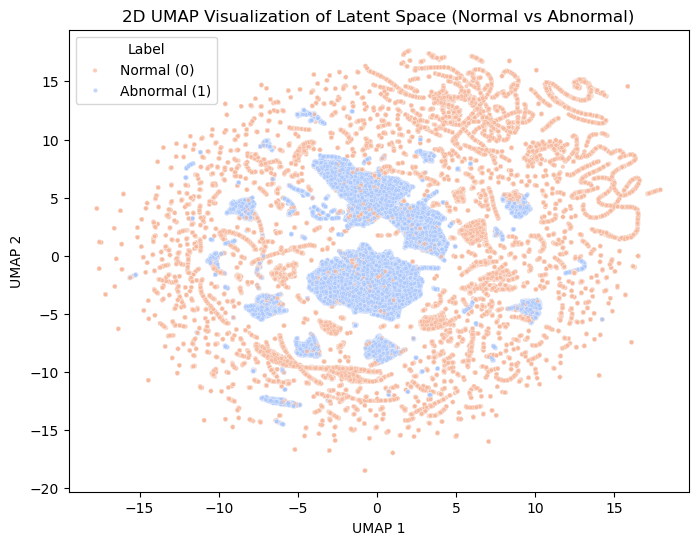

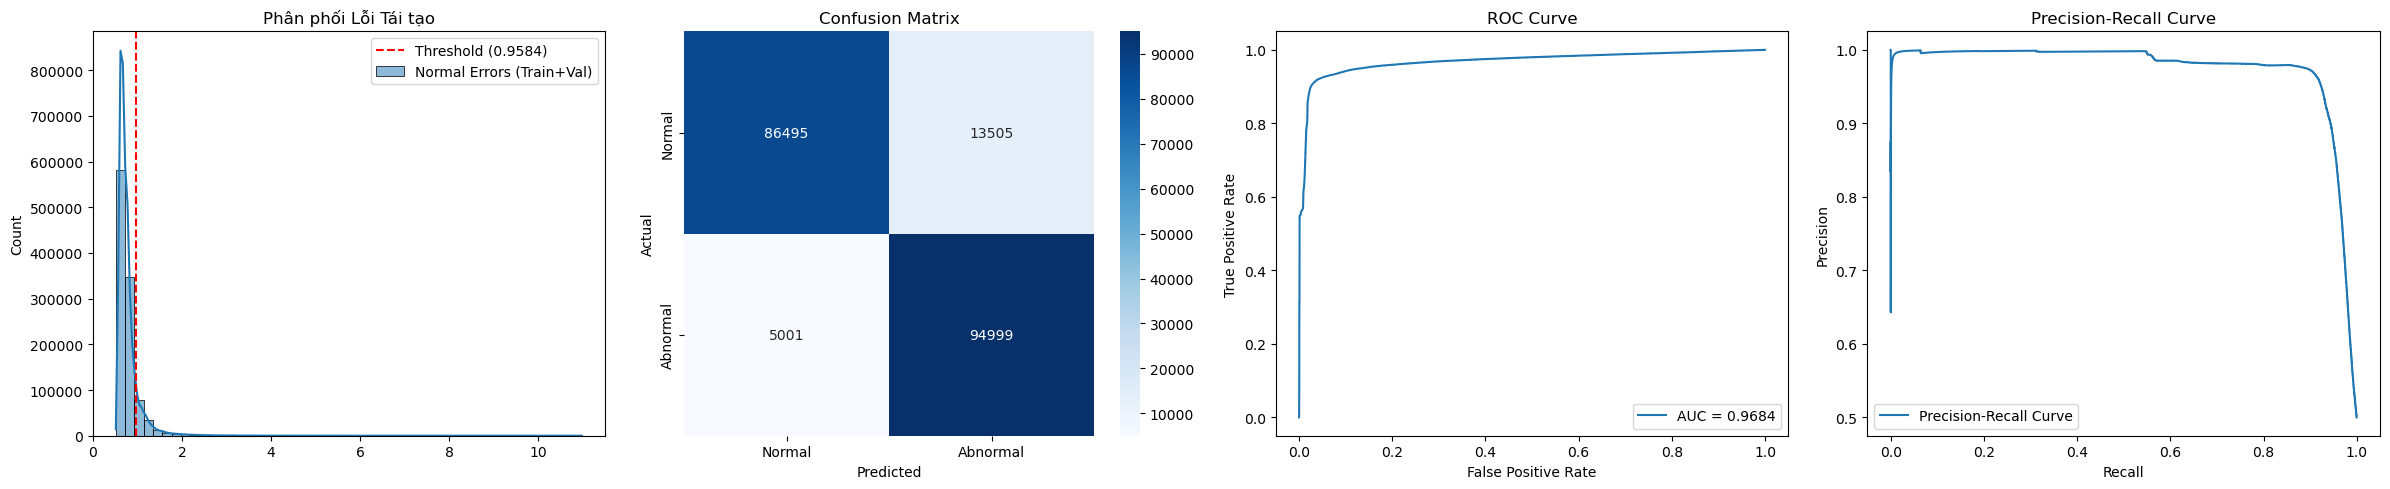

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import umap
import time
import warnings
warnings.filterwarnings('ignore')

# VAE Loss Function with beta
def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = nn.MSELoss(reduction='none')(reconstructed, original).mean(dim=1)  # per sample recon
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # per sample KL
    return recon_loss + beta * (kl_div / original.size(1))  # normalize KL by latent dim

# ============================
# Define Models
# ============================
class BasicAE(nn.Module):
    def __init__(self, input_dim=46, latent_dim=16):  # Tăng latent_dim
        super(BasicAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, input_dim))

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

class VAE(nn.Module):
    def __init__(self, input_dim=16, latent_dim=4):  # Giảm latent_dim cho regularize
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.BatchNorm1d(64), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.LeakyReLU(0.1)
        )
        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.BatchNorm1d(32), nn.LeakyReLU(0.1),
            nn.Linear(32, 64), nn.BatchNorm1d(64), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(64, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

# ===================================================================
# HÀM HUẤN LUYỆN (Thêm beta annealing)
# ===================================================================
def train_model(model, train_loader, val_loader, epochs, patience, learning_rate, model_save_path, denoising_std=0.005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print(f"Bắt đầu huấn luyện model '{model.__class__.__name__}'...")
    start_time = time.time()
    
    for epoch in range(epochs):
        beta = min(1.0, (epoch + 1) / (epochs * 0.2))  # Anneal beta from 0 to 1 over 20% epochs
        
        model.train()
        train_loss = 0
        for (data,) in train_loader:
            data = data.to(device)
            if denoising_std > 0:
                noise = torch.randn_like(data) * denoising_std
                noisy_data = data + noise
            else:
                noisy_data = data
            optimizer.zero_grad()
            if isinstance(model, VAE):
                reconstructed, mu, logvar = model(noisy_data)
                loss = vae_loss(reconstructed, data, mu, logvar, beta=beta).mean()  # mean over batch
            else:
                reconstructed = model(noisy_data)[0]
                loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(device)
                if isinstance(model, VAE):
                    reconstructed, mu, logvar = model(data)
                    loss = vae_loss(reconstructed, data, mu, logvar, beta=beta).mean()
                else:
                    reconstructed = model(data)[0]
                    loss = criterion(reconstructed, data)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Beta: {beta:.2f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break
            
    end_time = time.time()
    print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây. Model tốt nhất đã lưu vào '{model_save_path}'.\n")
    model.load_state_dict(torch.load(model_save_path))
    return model

# ============================
# 1. Load và chuẩn bị dữ liệu
# ============================
print("1. Đang load và chuẩn bị dữ liệu...")
try:
    train_data_raw = pd.read_csv('unsupervised_dataset.csv')
    test_data_raw = pd.read_csv('evaluation_dataset.csv')
    
    X_train_full = train_data_raw.apply(pd.to_numeric, errors='coerce').fillna(0).values
    X_test = test_data_raw.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_test = test_data_raw.iloc[:, -1].values
    y_test_binary = np.where(y_test == -1, 1, 0)
except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
    exit()

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

X_train_full_tensor = torch.FloatTensor(X_train_full_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

BATCH_SIZE = 256
full_loader = DataLoader(TensorDataset(X_train_full_tensor), batch_size=BATCH_SIZE, shuffle=True)

# ============================
# 2. AutoEncoder giảm chiều + Cleaning toàn bộ unsupervised data
# ============================
basic_ae = BasicAE(input_dim=X_train_full.shape[1])
basic_ae = train_model(basic_ae, full_loader, full_loader, epochs=100, patience=15, learning_rate=1e-3, model_save_path="best_basic_ae.pth", denoising_std=0.005)  # Train on full

# Compute errors on full for cleaning
basic_ae.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    reconstructed_full = basic_ae(X_train_full_tensor.to(device))[0]
    full_errors = torch.mean((X_train_full_tensor.to(device) - reconstructed_full)**2, dim=1).cpu().numpy()

# Clean: Remove top 2% high error (giảm để giữ nhiều data hơn)
clean_threshold = np.percentile(full_errors, 98)
clean_mask = full_errors < clean_threshold
X_train_clean_scaled = X_train_full_scaled[clean_mask]
print(f"Data cleaning: Kept {len(X_train_clean_scaled)} / {len(X_train_full_scaled)} samples.\n")

# Split train/val from clean data
X_train_split, X_val_split = train_test_split(X_train_clean_scaled, test_size=0.2, random_state=42)
X_train_clean_tensor = torch.FloatTensor(X_train_split)
X_val_tensor = torch.FloatTensor(X_val_split)

train_clean_loader = DataLoader(TensorDataset(X_train_clean_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=BATCH_SIZE, shuffle=False)

# Retrain BasicAE on clean train
basic_ae = BasicAE(input_dim=X_train_full.shape[1])
basic_ae = train_model(basic_ae, train_clean_loader, val_loader, epochs=100, patience=15, learning_rate=1e-3, model_save_path="best_basic_ae_clean.pth", denoising_std=0.005)

# Get latent
basic_ae.eval()
with torch.no_grad():
    _, latent_train = basic_ae(X_train_clean_tensor.to(device))
    _, latent_val = basic_ae(X_val_tensor.to(device))
    _, latent_test = basic_ae(X_test_tensor.to(device))

latent_scaler = StandardScaler()
X_train_latent_scaled = latent_scaler.fit_transform(latent_train.cpu().numpy())
X_val_latent_scaled = latent_scaler.transform(latent_val.cpu().numpy())
X_test_latent_scaled = latent_scaler.transform(latent_test.cpu().numpy())

X_train_latent_tensor = torch.FloatTensor(X_train_latent_scaled)
X_val_latent_tensor = torch.FloatTensor(X_val_latent_scaled)
X_test_latent_tensor = torch.FloatTensor(X_test_latent_scaled)

train_latent_loader = DataLoader(TensorDataset(X_train_latent_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_latent_loader = DataLoader(TensorDataset(X_val_latent_tensor), batch_size=BATCH_SIZE, shuffle=False)

# ============================
# 3. VAE cho anomaly detection
# ============================
anomaly_vae = VAE(input_dim=16)
anomaly_vae = train_model(anomaly_vae, train_latent_loader, val_latent_loader, epochs=300, patience=30, learning_rate=1e-4, model_save_path="best_anomaly_vae.pth", denoising_std=0.005)

# ============================
# 4. Đánh giá (Sử dụng ELBO per sample)
# ============================
print("4. Đánh giá mô hình...")
anomaly_vae.eval()
with torch.no_grad():
    reconstructed_train, mu_train, logvar_train = anomaly_vae(X_train_latent_tensor.to(device))
    train_errors = vae_loss(reconstructed_train, X_train_latent_tensor.to(device), mu_train, logvar_train, beta=1.0).cpu().numpy()  # full ELBO
    
    reconstructed_val, mu_val, logvar_val = anomaly_vae(X_val_latent_tensor.to(device))
    val_errors = vae_loss(reconstructed_val, X_val_latent_tensor.to(device), mu_val, logvar_val, beta=1.0).cpu().numpy()
    
    reconstructed_test, mu_test, logvar_test = anomaly_vae(X_test_latent_tensor.to(device))
    test_errors = vae_loss(reconstructed_test, X_test_latent_tensor.to(device), mu_test, logvar_test, beta=1.0).cpu().numpy()

train_val_errors = np.concatenate([train_errors, val_errors])

# Optimize threshold
precisions, recalls, thresholds = precision_recall_curve(y_test_binary, test_errors)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
threshold = thresholds[best_idx]
print(f"Threshold tối ưu từ F1-max: {threshold:.6f}")

target_recall = 0.95
idx = np.where(recalls >= target_recall)[0][-1]
high_recall_threshold = thresholds[idx]
print(f"Threshold cho recall >= {target_recall}: {high_recall_threshold:.6f}")

# Evaluate
y_pred_binary = (test_errors > high_recall_threshold).astype(int)
auc = roc_auc_score(y_test_binary, test_errors)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')

print(f"\n=== KẾT QUẢ ĐÁNH GIÁ (High Recall Threshold) ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Threshold: {high_recall_threshold:.6f}\n")

# ============================
# 5. Trực quan hóa
# ============================
print("5. Vẽ biểu đồ trực quan hóa...")
print("Đang giảm chiều bằng UMAP để trực quan hóa...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
latent_test_2d = reducer.fit_transform(X_test_latent_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_test_2d[:, 0], y=latent_test_2d[:, 1], hue=y_test_binary, palette='coolwarm', s=10, alpha=0.7)
plt.title('2D UMAP Visualization of Latent Space (Normal vs Abnormal)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label', labels=['Normal (0)', 'Abnormal (1)'])
plt.savefig('umap_latent_space_viz_improved.png')
plt.show()

plt.figure(figsize=(24, 5))
plt.subplot(1, 4, 1)
sns.histplot(train_val_errors, bins=50, kde=True, label='Normal Errors (Train+Val)')
plt.axvline(high_recall_threshold, color='r', linestyle='--', label=f'Threshold ({high_recall_threshold:.4f})')
plt.title('Phân phối Lỗi Tái tạo')
plt.legend()

plt.subplot(1, 4, 2)
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 4, 3)
fpr, tpr, _ = roc_curve(y_test_binary, test_errors)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.savefig("final_evaluation_charts_improved.png")
plt.show()